In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

data_dir = './var/'
SEED = 123

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the dataset

In [49]:
df_bcell = pd.read_csv('/input_bcell.csv')
df_sars = pd.read_csv('/input_sars.csv')
df = pd.concat([df_bcell, df_sars], ignore_index=True)
df.head()
df_covid = pd.read_csv('/input_covid.csv')
df_covid.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability
0,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,1,5,MGILP,0.948,0.280,1.033,-2.72,6.03595,0.10929,-0.138642,31.377603
1,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,2,6,GILPS,1.114,0.379,1.070,-0.58,6.03595,0.10929,-0.138642,31.377603
2,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,3,7,ILPSP,1.106,0.592,1.108,-1.30,6.03595,0.10929,-0.138642,31.377603
3,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,4,8,LPSPG,1.324,0.836,1.053,1.44,6.03595,0.10929,-0.138642,31.377603
4,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,5,9,PSPGM,1.326,1.004,0.968,2.44,6.03595,0.10929,-0.138642,31.377603


## Preprocessing

In [51]:
# feature columns
feature_cols = [col for col in df.columns if col not in ['parent_protein_id', 'protein_seq', 'peptide_seq','target']]
print(feature_cols)

# split df into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df.target, test_size=0.2, random_state=SEED)
y_train = y_train.to_frame()
y_test = y_test.to_frame()

# normalization
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=feature_cols)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=feature_cols)

['start_position', 'end_position', 'chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 'isoelectric_point', 'aromaticity', 'hydrophobicity', 'stability']


In [17]:
print(df[df.target==0].shape[0])
print(df[df.target==1].shape[0])

10865
4042


In [52]:
def train_model(model, X_train=X_train, y_train=y_train, nfold=7):
    skf = StratifiedKFold(n_splits = nfold, shuffle=True, random_state = SEED)

    train_loss, val_loss, test_loss = [], [],[]
    train_accu, val_accu, test_accu = [], [], []
    train_prec, val_prec, test_prec = [], [], []
    train_recall, val_recall, test_recall = [], [], []
    train_f1, val_f1, test_f1 = [], [], []
    for train_index, val_index in skf.split(X_train, y_train):
        train, val = X_train.iloc[train_index], X_train.iloc[val_index]
        train_targets, val_targets = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(train, train_targets)

        train_pred_proba = model.predict_proba(train)
        val_pred_proba = model.predict_proba(val)
        test_pred_proba = model.predict_proba(X_test)
        # neg log loss
        train_loss.append(log_loss(train_targets, train_pred_proba))
        val_loss.append(log_loss(val_targets, val_pred_proba))
        test_loss.append(log_loss(y_test, test_pred_proba))

        train_pred = model.predict(train)
        val_pred = model.predict(val)
        test_pred = model.predict(X_test)
        # accuracy
        train_accu.append(accuracy_score(train_targets, train_pred))
        val_accu.append(accuracy_score(val_targets, val_pred))
        test_accu.append(accuracy_score(y_test, test_pred))
        # precision
        train_prec.append(precision_score(train_targets, train_pred))
        val_prec.append(precision_score(val_targets, val_pred))
        test_prec.append(precision_score(y_test, test_pred))
        # recall
        train_recall.append(recall_score(train_targets, train_pred))
        val_recall.append(recall_score(val_targets, val_pred))
        test_recall.append(recall_score(y_test, test_pred))
        # f1 score
        train_f1.append(f1_score(train_targets, train_pred))
        val_f1.append(f1_score(val_targets, val_pred))
        test_f1.append(f1_score(y_test, test_pred))


    print('Training loss : ', np.average(np.array(train_loss)))
    print('Validation loss : ', np.average(np.array(val_loss)))
    print('Test loss : ', np.average(np.array(test_loss)))

    train_accu_avg = np.average(np.array(train_accu))
    train_prec_avg = np.average(np.array(train_prec))
    train_recall_avg = np.average(np.array(train_recall))
    train_f1_avg = np.average(np.array(train_f1))
    print('Train accuracy {:5f}, precision {:5f}, recall {:5f}, f1 {:5f} '.format(train_accu_avg, train_prec_avg, train_recall_avg, train_f1_avg))

    val_accu_avg = np.average(np.array(val_accu))
    val_prec_avg = np.average(np.array(val_prec))
    val_recall_avg = np.average(np.array(val_recall))
    val_f1_avg = np.average(np.array(val_f1))
    print('Valid accuracy {:5f}, precision {:5f}, recall {:5f}, f1 {:5f} '.format(val_accu_avg, val_prec_avg, val_recall_avg, val_f1_avg))

    test_accu_avg = np.average(np.array(test_accu))
    test_prec_avg = np.average(np.array(test_prec))
    test_recall_avg = np.average(np.array(test_recall))
    test_f1_avg = np.average(np.array(test_f1))
    print('Test  accuracy {:5f}, precision {:5f}, recall {:5f}, f1 {:5f} '.format(test_accu_avg, test_prec_avg, test_recall_avg, test_f1_avg))

## Modeling: Logistic Regression  

In [9]:
# model with default parameters
model = LogisticRegression(penalty='l2',random_state=SEED)
train_model(model)

Training loss :  0.5548469361260543
Validation loss :  0.5557078990563984
Test loss :  0.5604272467321073
Train accuracy 0.734815, precision 0.598210, recall 0.060550, f1 0.109939 
Valid accuracy 0.734927, precision 0.602372, recall 0.061378, f1 0.111090 
Test  accuracy 0.731101, precision 0.577338, recall 0.064951, f1 0.116734 


In [23]:
model = LogisticRegression(penalty='l1',solver='liblinear',random_state=SEED)
train_model(model)

Training loss :  0.5547379541357689
Validation loss :  0.5556589013715297
Test loss :  0.5603998389150148
Train accuracy 0.734703, precision 0.596421, recall 0.060136, f1 0.109229 
Valid accuracy 0.734591, precision 0.596476, recall 0.060449, f1 0.109483 
Test  accuracy 0.730909, precision 0.574128, recall 0.064601, f1 0.116102 


In [13]:
# model with default parameters
model = LogisticRegression(penalty='none',random_state=SEED)
train_model(model)

Training loss :  0.5540715655035748
Validation loss :  0.5549880765593196
Test loss :  0.5607791729914318
Train accuracy 0.733725, precision 0.573059, recall 0.061996, f1 0.111864 
Valid accuracy 0.733837, precision 0.575461, recall 0.062619, f1 0.112689 
Test  accuracy 0.728610, precision 0.534691, recall 0.065826, f1 0.117179 


In [37]:
# GridSearch 
model = LogisticRegression(random_state = SEED)
params = {'C':[.1,50, 100,500, 10000, 50000]}
gcv = GridSearchCV(model, params, scoring='neg_log_loss')
gcv.fit(X_train, y_train)
print('Best parameter: ', gcv.best_params_)

Best parameter:  {'C': 500}


In [39]:
model = LogisticRegression(C=10000, random_state=SEED)
train_model(model)

Training loss :  0.5540715667987695
Validation loss :  0.5549879254335282
Test loss :  0.5607774946545552
Train accuracy 0.733725, precision 0.573059, recall 0.061996, f1 0.111864 
Valid accuracy 0.733837, precision 0.575461, recall 0.062619, f1 0.112689 
Test  accuracy 0.728610, precision 0.534691, recall 0.065826, f1 0.117179 


In [40]:
model.coef_

array([[-1.01027646e+01,  9.83659839e+00,  2.33283485e-01,
         1.57182659e-01, -7.56391730e-02, -1.53962006e-01,
        -3.32155423e-01,  4.71614134e-03,  2.73361720e-01,
         2.31431244e-01]])

In [41]:
# feature importance
model = LogisticRegression(C=10000, random_state=SEED)
model.fit(X_train, y_train)
importances = [abs(model.coef_[0][i]) for i in range(len(feature_cols))]
_sum = sum(importances)
importances = [x/_sum for x in importances]
feature_import = [(feature_cols[i], importances[i]) for i in range(len(feature_cols))]
feature_import = sorted(feature_import, key=lambda x:x[1])
print(feature_import)

[('aromaticity', 0.0005464078574760544), ('kolaskar_tongaonkar', 0.0037869931633599434), ('emini', 0.006772017051978455), ('parker', 0.006924428604195673), ('stability', 0.010668019264121533), ('chou_fasman', 0.010853350271145592), ('hydrophobicity', 0.013172879850985102), ('isoelectric_point', 0.0160934038060767), ('end_position', 0.4591603991370059), ('start_position', 0.4720221009936554)]


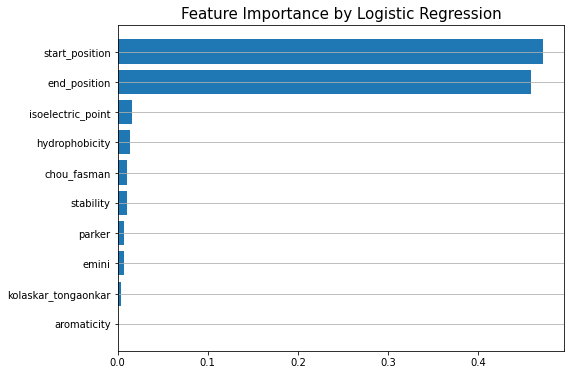

In [42]:
plt.figure(figsize=(8, 6))
plt.barh([x[0] for x in feature_import], [x[1] for x in feature_import])
plt.title('Feature Importance by Logistic Regression',Fontsize=15)
plt.grid(axis='y')

## Modeling: Random Forest 

In [43]:
# model with default parameters
RandomForestClassifier(random_state = SEED)
train_model(model)

Training loss :  0.5540715667987695
Validation loss :  0.5549879254335282
Test loss :  0.5607774946545552
Train accuracy 0.733725, precision 0.573059, recall 0.061996, f1 0.111864 
Valid accuracy 0.733837, precision 0.575461, recall 0.062619, f1 0.112689 
Test  accuracy 0.728610, precision 0.534691, recall 0.065826, f1 0.117179 


In [44]:
# Gridsearch 
model = RandomForestClassifier(random_state = SEED)
params = {'max_depth':[15, 16, 17, 18, 19]}
gcv = GridSearchCV(model, params, scoring='neg_log_loss')
gcv.fit(X_train, y_train)
print('Best parameter: ', gcv.best_params_)

Best parameter:  {'max_depth': 18}


In [71]:
model = RandomForestClassifier(max_depth=18, random_state=SEED)
train_model(model)

Training loss :  0.12070216386551061
Validation loss :  0.3511769583896269
Test loss :  0.36988480299029
Train accuracy 0.988679, precision 0.999838, recall 0.958307, f1 0.978632 
Valid accuracy 0.852075, precision 0.776575, recall 0.636695, f1 0.699243 
Test  accuracy 0.849717, precision 0.782149, recall 0.624825, f1 0.694678 


In [68]:
# Feature importance
model = RandomForestClassifier(max_depth=18, random_state=SEED)
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_import = [(feature_cols[i], abs(importances[i])) for i in range(len(feature_cols))]
feature_import = sorted(feature_import, key=lambda x:x[1])
print(feature_import)

[('kolaskar_tongaonkar', 0.07819469199507226), ('parker', 0.08452496013044604), ('chou_fasman', 0.08499849652011747), ('emini', 0.08902621982085838), ('end_position', 0.09830357886604645), ('start_position', 0.09831542821166599), ('stability', 0.10392867868782123), ('aromaticity', 0.10837875779918013), ('isoelectric_point', 0.11692126073893003), ('hydrophobicity', 0.13740792722986211)]


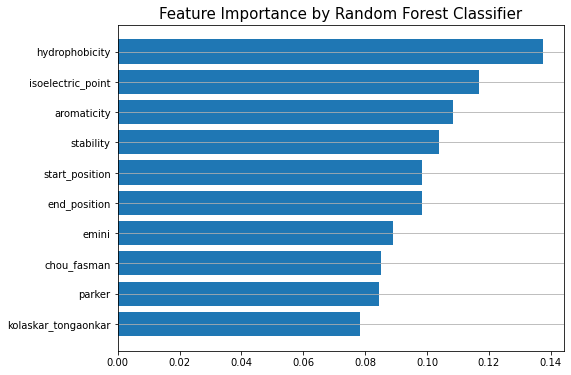

In [69]:
plt.figure(figsize=(8, 6))
plt.barh([x[0] for x in feature_import], [x[1] for x in feature_import])
plt.title('Feature Importance by Random Forest Classifier',Fontsize=15)
plt.grid(axis='y')

In [76]:
#model.predict(df_covid)
feature_cols = [col for col in df_covid.columns if col not in ['parent_protein_id', 'protein_seq', 'peptide_seq','target']]
df_covid= df_covid[feature_cols]
# split df into training set and test set
##df_covid = df_covid.to_frame()

# normalization
scaler = StandardScaler()
#df_covid = pd.DataFrame(scaler.fit_transform(df_covid), index=df_covid.index, columns=feature_cols)
#X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=feature_cols)

In [124]:
predictions = model.predict(df_covid)

target = (predictions == 1).sum()
nontarget = (predictions == 0).sum()
df_covid.shape

(20312, 10)

Text(0.5, 1.0, 'Outputed Labels for Random Forest')

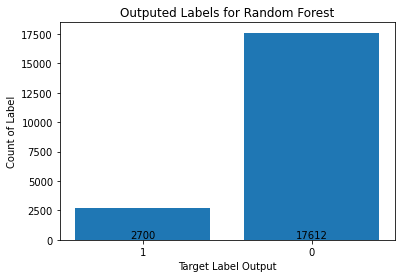

In [123]:
import matplotlib.pyplot as plt
vals=[target,nontarget]
inds=range(len(vals))
labels=['1','0']

fig,ax = plt.subplots()
rects = ax.bar(inds, vals)
ax.set_xticks([ind for ind in inds])
ax.set_xticklabels(labels)

plt.annotate(str(target),xy=(0,0), ha='center', va='bottom')
plt.annotate(str(nontarget),xy=(1,0), ha='center', va='bottom')
plt.xlabel("Target Label Output")
plt.ylabel("Count of Label")
plt.title("Outputed Labels for Random Forest")

## Gradient Boosting

In [67]:
# Gridsearch 
model = XGBClassifier(random_state = SEED)
params = {'max_depth':[4,5,6,7,8,]}
gcv = GridSearchCV(model, params, scoring='neg_log_loss')
gcv.fit(X_train, y_train)
print('Best parameter: ', gcv.best_params_)

Best parameter:  {'max_depth': 8}


In [125]:
model = XGBClassifier(max_depth=6, random_state=SEED)
train_model(model)

Training loss :  0.2980598460060227
Validation loss :  0.3793879985673036
Test loss :  0.39412517043833917
Train accuracy 0.886513, precision 0.877685, recall 0.674520, f1 0.762773 
Valid accuracy 0.835472, precision 0.769907, recall 0.558591, f1 0.647145 
Test  accuracy 0.828255, precision 0.766362, recall 0.535714, f1 0.630596 


In [127]:
predictions = model.predict(df_covid)

target = (predictions == 1).sum()
nontarget = (predictions == 0).sum()


(20312,)

Text(0.5, 1.0, 'Outputed Labels for Gradient Boosting Model')

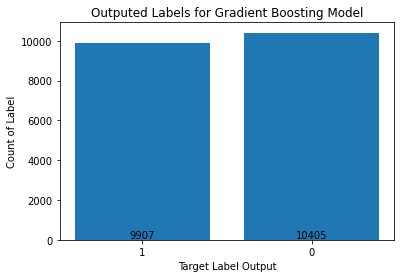

In [128]:
import matplotlib.pyplot as plt
vals=[target,nontarget]
inds=range(len(vals))
labels=['1','0']

fig,ax = plt.subplots()
rects = ax.bar(inds, vals)
ax.set_xticks([ind for ind in inds])
ax.set_xticklabels(labels)

plt.annotate(str(target),xy=(0,0), ha='center', va='bottom')
plt.annotate(str(nontarget),xy=(1,0), ha='center', va='bottom')
plt.xlabel("Target Label Output")
plt.ylabel("Count of Label")
plt.title("Outputed Labels for Gradient Boosting Model")

In [61]:
# feature importance

model.fit(X_train, y_train)
importances = model.feature_importances_
feature_import = [(feature_cols[i], abs(importances[i])) for i in range(len(feature_cols))]
feature_import = sorted(feature_import, key=lambda x:x[1])
print(feature_import)

[('kolaskar_tongaonkar', 0.035858802), ('parker', 0.043975797), ('chou_fasman', 0.050685994), ('start_position', 0.051220547), ('emini', 0.062352564), ('end_position', 0.077438936), ('aromaticity', 0.13466804), ('stability', 0.1369486), ('isoelectric_point', 0.17412984), ('hydrophobicity', 0.23272087)]


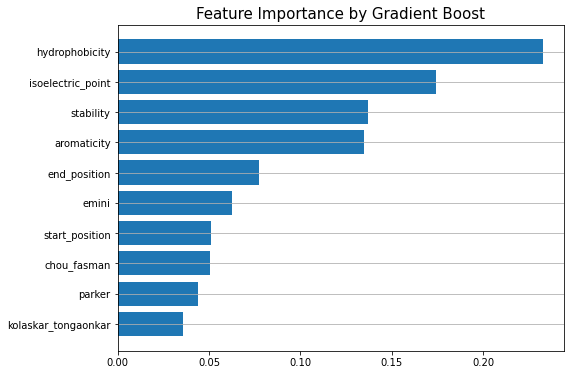

In [63]:
plt.figure(figsize=(8, 6))
plt.barh([x[0] for x in feature_import], [x[1] for x in feature_import])
plt.title('Feature Importance by Gradient Boost',Fontsize=15)
plt.grid(axis='y')

NameError: ignored

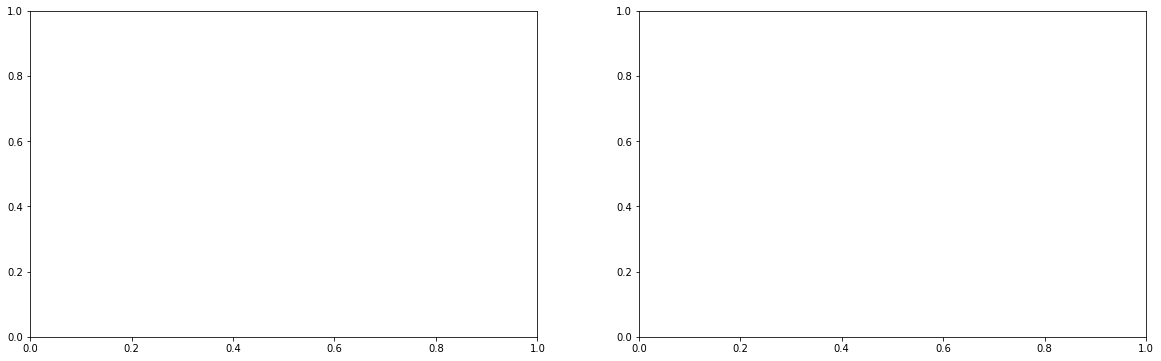

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.distplot(df_target['chou_fasman'],ax=ax[0],label='target=1')
sns.distplot(df_nontarget['chou_fasman'],ax=ax[0],label='target=0')
ax[0].legend()
ax[0].set_title('chou fasman distribution')
pep_bychou = df.groupby('target')['chou_fasman'].mean().reset_index()
sns.barplot(x = pep_bychou['target'],y=pep_bychou['chou_fasman'])
ax[1].set_ylim(0.95,1.02)
ax[1].set_title('average chou fasman by target')